In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram

In [45]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Combo"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 100
NUM_SETTINGS = 20
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/u9j20axx/checkpoints/epoch=767-step=160512.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
PEAK_NORMALISE = True

In [46]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [ ]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=131_072,
        effect_audio=False,
        dummy_setting=False
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [49]:
dafx = dafx_from_name(DAFX_NAME)

In [50]:
def get_interpolated_settings(dafx, setting_idx, num_samples=100):
    num_settings = len(dafx.param_names)

    assert(setting_idx <= num_settings)

    settings = []
    for i in np.linspace(0,1, num_samples):
        s = torch.ones(num_settings) * 0.5
        s[setting_idx] = i
        settings.append(s)

    return settings

In [51]:
settings_to_apply = get_interpolated_settings(dafx, 1, 10)

In [52]:
settings_to_apply

[tensor([0.5000, 0.0000, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.1111, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.2222, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.3333, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.4444, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.5556, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.6667, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.7778, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 0.8889, 0.5000, 0.5000, 0.5000]),
 tensor([0.5000, 1.0000, 0.5000, 0.5000, 0.5000])]

In [53]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=256, bias=True)
  (log_var): Linear(in_features=20640, 

In [54]:
model.device

device(type='cuda', index=0)

In [55]:
latent_embeddings = dict()

In [56]:
dataset = get_dataset(dafx_from_name('clean'))

100%|█████████████████████████████████████████| 88/88 [00:00<00:00, 2706.68it/s]


Loaded 88 files for train = 66.89 hours.


In [57]:
from tqdm import tqdm

for i in range(dafx.get_num_params()):
    setting_name = dafx.idx_to_param_map[i]
    print(f"Interpolating setting: {setting_name}")
    embeddings = []
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    for setting in settings_to_apply:
        print(f"Applying setting: {setting}")
        for batch in tqdm(dataset):
            x = batch

            # Apply setting to audio
            x = dafx.apply(x, setting)
            x = x.unsqueeze(0).unsqueeze(0)

            X = audio_to_spectrogram(signal=x).to(DEVICE)

            _, _, _, z = model(X)

            embeddings.append(z.cpu().detach().numpy())

        latent_embeddings[setting_name] = np.array(embeddings)


Interpolating setting: drive_s_h
Applying setting: tensor([0.0000, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Applying setting: tensor([0.0526, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Applying setting: tensor([0.1053, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Applying setting: tensor([0.1579, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Applying setting: tensor([0.2105, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


Applying setting: tensor([0.2632, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.54it/s]


Applying setting: tensor([0.3158, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.06it/s]


Applying setting: tensor([0.3684, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 21.13it/s]


Applying setting: tensor([0.4211, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.28it/s]


Applying setting: tensor([0.4737, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.32it/s]


Applying setting: tensor([0.5263, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


Applying setting: tensor([0.5789, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


Applying setting: tensor([0.6316, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Applying setting: tensor([0.6842, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


Applying setting: tensor([0.7368, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Applying setting: tensor([0.7895, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.89it/s]


Applying setting: tensor([0.8421, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 22.29it/s]


Applying setting: tensor([0.8947, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.68it/s]


Applying setting: tensor([0.9474, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


Applying setting: tensor([1.0000, 0.5000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.70it/s]


Interpolating setting: bias
Applying setting: tensor([0.5000, 0.0000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.53it/s]


Applying setting: tensor([0.5000, 0.0526, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Applying setting: tensor([0.5000, 0.1053, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 21.17it/s]


Applying setting: tensor([0.5000, 0.1579, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 22.84it/s]


Applying setting: tensor([0.5000, 0.2105, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


Applying setting: tensor([0.5000, 0.2632, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


Applying setting: tensor([0.5000, 0.3158, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


Applying setting: tensor([0.5000, 0.3684, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


Applying setting: tensor([0.5000, 0.4211, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 22.21it/s]


Applying setting: tensor([0.5000, 0.4737, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Applying setting: tensor([0.5000, 0.5263, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


Applying setting: tensor([0.5000, 0.5789, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Applying setting: tensor([0.5000, 0.6316, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.34it/s]


Applying setting: tensor([0.5000, 0.6842, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Applying setting: tensor([0.5000, 0.7368, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Applying setting: tensor([0.5000, 0.7895, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Applying setting: tensor([0.5000, 0.8421, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Applying setting: tensor([0.5000, 0.8947, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 22.77it/s]


Applying setting: tensor([0.5000, 0.9474, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.07it/s]


Applying setting: tensor([0.5000, 1.0000, 0.5000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Interpolating setting: output_db
Applying setting: tensor([0.5000, 0.5000, 0.0000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


Applying setting: tensor([0.5000, 0.5000, 0.0526, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.21it/s]


Applying setting: tensor([0.5000, 0.5000, 0.1053, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


Applying setting: tensor([0.5000, 0.5000, 0.1579, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


Applying setting: tensor([0.5000, 0.5000, 0.2105, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.53it/s]


Applying setting: tensor([0.5000, 0.5000, 0.2632, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


Applying setting: tensor([0.5000, 0.5000, 0.3158, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.26it/s]


Applying setting: tensor([0.5000, 0.5000, 0.3684, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 22.18it/s]


Applying setting: tensor([0.5000, 0.5000, 0.4211, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


Applying setting: tensor([0.5000, 0.5000, 0.4737, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5263, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.91it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5789, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


Applying setting: tensor([0.5000, 0.5000, 0.6316, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.24it/s]


Applying setting: tensor([0.5000, 0.5000, 0.6842, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Applying setting: tensor([0.5000, 0.5000, 0.7368, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Applying setting: tensor([0.5000, 0.5000, 0.7895, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 32.59it/s]


Applying setting: tensor([0.5000, 0.5000, 0.8421, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.09it/s]


Applying setting: tensor([0.5000, 0.5000, 0.8947, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Applying setting: tensor([0.5000, 0.5000, 0.9474, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.85it/s]


Applying setting: tensor([0.5000, 0.5000, 1.0000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


Interpolating setting: hpf_freq
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.0000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 21.12it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.0526, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.12it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.1053, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.64it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.1579, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.2105, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 22.95it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.2632, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.93it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.3158, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.01it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.3684, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.4211, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.58it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.4737, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5263, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.40it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5789, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.6316, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.80it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.6842, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.7368, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.7895, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.8421, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 23.67it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.8947, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.9474, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 1.0000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


Interpolating setting: hpf_reso
Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.0000])


100%|██████████| 100/100 [00:03<00:00, 31.60it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.0526])


100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.1053])


100%|██████████| 100/100 [00:03<00:00, 26.32it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.1579])


100%|██████████| 100/100 [00:03<00:00, 30.15it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.2105])


100%|██████████| 100/100 [00:03<00:00, 26.22it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.2632])


100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.3158])


100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.3684])


100%|██████████| 100/100 [00:03<00:00, 26.19it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.4211])


100%|██████████| 100/100 [00:04<00:00, 23.82it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.4737])


100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5263])


100%|██████████| 100/100 [00:04<00:00, 22.05it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5789])


100%|██████████| 100/100 [00:03<00:00, 26.24it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.6316])


100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.6842])


100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.7368])


100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.7895])


100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.8421])


100%|██████████| 100/100 [00:04<00:00, 21.85it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.8947])


100%|██████████| 100/100 [00:03<00:00, 25.92it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.9474])


100%|██████████| 100/100 [00:03<00:00, 28.64it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5000, 0.5000, 1.0000])


100%|██████████| 100/100 [00:04<00:00, 24.11it/s]


In [58]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [59]:
data.shape

(10000, 256)

In [60]:
import umap

In [61]:
reducer = umap.UMAP().fit(data)

In [62]:
import seaborn as sns

sns.set()

In [63]:
EXPERIMENT_NAME = f"{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{NUM_SETTINGS}settings"

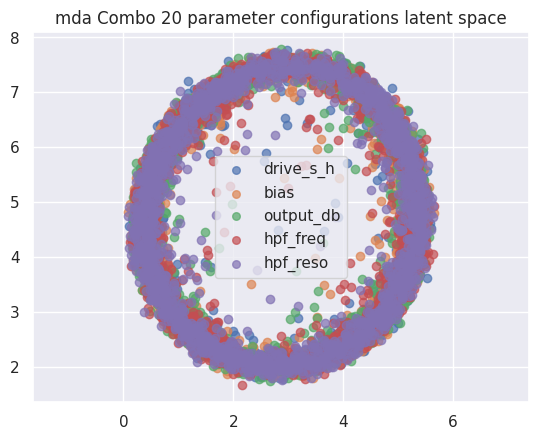

In [64]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.7)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_full.png"
plt.savefig(figname)

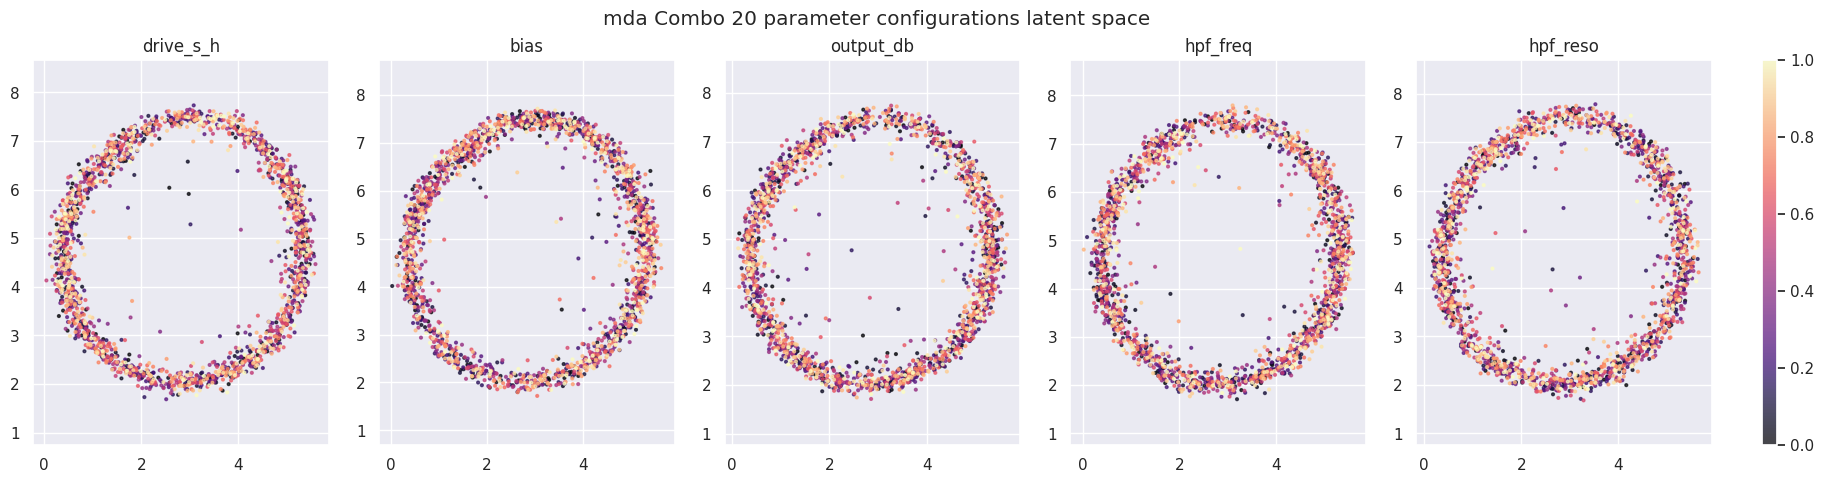

In [65]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(4.5*dafx.get_num_params(), 5))
gs = gridspec.GridSpec(1, dafx.get_num_params() + 1, width_ratios=[1]*dafx.get_num_params() + [0.05])

for i in range(dafx.get_num_params()):
    param_name = dafx.idx_to_param_map[i]
    X = latent_embeddings[param_name]

    embeds = reducer.transform(X.squeeze())
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

    ax = fig.add_subplot(gs[0, i])
    sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], alpha=0.7, s=4, c=colours, vmin=0, vmax=1, cmap='magma')

    ax.set_title(param_name)
    ax.set_aspect('equal', 'datalim')

plt.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(sc, cax=cax)

fig.subplots_adjust(right=0.9)

figname = f"./figures/param_interpolation/{EXPERIMENT_NAME}_seperate.png"
plt.savefig(figname)